In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Bibliotecas
# Webscrapping
import requests as rq
import json
from pandas.io.json import json_normalize

# Tratamento e análise
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 1. Webscrapping

In [ ]:
#Configura o display do pandas
pd.options.display.max_columns = 99
pd.options.display.max_rows = 99

#Imita um navegador para passar restricoes
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'
headers = {'User-Agent': user_agent}

#Variaveis fixas
vPagFinal = 10          #Numero total de paginas a serem buscadas, se houver menos o script controla
vTransacao = "venda"    #Tipo de transacao: venda ou aluguel

#Listas para o script pegar automaticamente, pode aumentar ou diminuir com novos dados
vImovelLista = ["apartamentos"]   #"casas","casas-de-vila","casas-de-condominio"
vZonaLista = ["TODOS"] #"zona-norte","centro","zona-sul", "zona-oeste", "zona-leste", "TODOS", etc
vBairroLista = ["TODOS"]   #"barra-da-tijuca","pechincha","freguesia-jacarepagua","anil" ou "TODOS" para pesquisar todos de determinada area
vQuartos = 4          #Quantidade de quartos
vValorMin = 50000      #Valor Minimo
vValorMax = 1000000     #Valor Maximo

# https://www.zapimoveis.com.br/venda/apartamentos/ce+fortaleza/

def get_list_imoveis(vUF: str, vCidadeLista: list):
  #Para cada cidade na lista
  for vCidade in vCidadeLista:
      #para cada zona na lista de Zonas
      for vZona in vZonaLista:
          #Para cada bairro na lista de Bairros
          for vBairro in vBairroLista:
              #Para cada imovel na lista de imoveis
              for vImovel in vImovelLista:

                  #Define a pagina inicial
                  vPagina = 1

                  #Print dos dados para acompanhar
                  print(vCidade + ' -> ' + vZona + ' -> ' + vBairro + ' -> ' + vImovel + ' -> ' + str(vQuartos))

                  #Teste se o Bairro é unico, alguns ou todos
                  if vBairro == 'TODOS':
                      if vZona == 'TODOS':
                          if vCidade == 'TODOS':
                              vURL_B = "https://www.zapimoveis.com.br/" + vTransacao + "/" + vImovel + "/" + str(vQuartos) + "-Quartos"
                          else:
                              vURL_B = "https://www.zapimoveis.com.br/" + vTransacao + "/" + vImovel + "/" + vUF + "+" + vCidade
                      else:
                          vURL_B = "https://www.zapimoveis.com.br/" + vTransacao + "/" + vImovel + "/" + vUF + "+" + vCidade + "+" + vZona + "/" + str(vQuartos) + "-Quartos"
                  else:
                      vURL_B = "https://www.zapimoveis.com.br/" + vTransacao + "/" + vImovel + "/" + vUF + "+" + vCidade + "+" + vZona + "+" + vBairro + "/" + str(vQuartos) + "-Quartos"

                  #Cria o dicionario
                  dfs = {}

                  #Itera entre as paginas
                  while vPagina <= vPagFinal:

                      #URL
                      vURL = vURL_B + "/?pagina=" + str(vPagina) + "&precoMinimo=" + str(vValorMin) + "&precoMaximo=" + str(vValorMax)

                      # print('Pagina: ' + str(vPagina))
                      #print(vURL)
                      #Testa o codigo de retorno do site
                      # print(vURL+'\n')
                      vResp = rq.get(vURL,headers=headers)
                      vStat = vResp.status_code

                      #Se codigo 200, entao vai adiante
                      if vStat == 200:
                          vHTML = vResp.text
                          vHTML = str(vHTML)

                          #Valida se a pagina existe ou nao
                          vValPag = 'OK' if 'Não encontramos resultados' in vHTML else 'NOK'

                          #Continua se a pagina existir
                          if vValPag == 'NOK':

                              #Pega apenas a parte do Json do codigo fonte
                              vHTML = vHTML.split('"results":{"listings":[',1)[1]
                              vHTML = vHTML.split('],"nearbyListings":[]',1)[0]
                              vHTML = vHTML.split(',"type":"nearby"}]',1)[0]

                              #Ao dar erro de delimitador, adicionar ou retirar chaves antes do colchetes na variavel abaixo
                              #Valida o fim da string, pois para alguns casos vem com char a menos
                              if vHTML[-2:] == '}}':
                                  v1 = '{"listings":[' + vHTML + ']}'
                              elif vHTML[-10:] == '"premium"}':
                                  vHTML = vHTML.split(',"type":"premium"}',1)[0]
                                  #vHTML = vHTML.split(vHTML[-18],1)[0]
                                  v1 = '{"listings":[' + vHTML + '}]}'
                              else:
                                  v1 = '{"listings":[' + vHTML + '}]}'

                              #Retira a marcacao de moeda, deixando apenas o valor
                              v1 = v1.replace('R$ ','')
                              v1 = v1.replace(',"superPremiumListings":[}]}','}')
                              v1 = v1.split(';(function',1)[0]
                              v1 = v1.split(',"advertisers"',1)[0]

                              # print(v1)
                              j = json.loads(v1)

                              #Cria o dataframe do pandas, já normalizando o json
                              df = json_normalize(j['listings'])

                              #Deixa somente as colunas utilizaveis
                              df = df[['type','link.href','account.name','listing.usableAreas','listing.totalAreas','listing.title','listing.description','listing.createdAt','listing.updatedAt','listing.floors',
                                        'listing.parkingSpaces','listing.address.zipCode','listing.address.street','listing.address.neighborhood','listing.address.streetNumber','listing.suites',
                                        'listing.bathrooms','listing.bedrooms','listing.advertiserContact.phones','listing.whatsappNumber','listing.pricingInfo.salePrice','listing.pricingInfo.yearlyIptu',
                                        'listing.pricingInfo.monthlyCondoFee','listing.publicationType','listing.unitTypes','listing.unitSubTypes','listing.usageTypes','listing.amenities']]

                              #Insere a coluna com o tipo de imovel
                              df['imvl_type'] = vImovel

                              #Tratamento dos dados
                              df['listing.publicationType'] = df['listing.publicationType'].fillna('Standard')

                              #Retira o colchetes, transformando a lista em string dentro da coluna
                              df['listing.floors'] = [''.join(map(str, l)) for l in df['listing.floors']]
                              df['listing.unitTypes'] = [''.join(map(str, l)) for l in df['listing.unitTypes']]
                              df['listing.unitSubTypes'] = ['|'.join(map(str, l)) for l in df['listing.unitSubTypes']]
                              df['listing.parkingSpaces'] = [''.join(map(str, l)) for l in df['listing.parkingSpaces']]
                              df['listing.suites'] = [''.join(map(str, l)) for l in df['listing.suites']]
                              df['listing.bathrooms'] = [''.join(map(str, l)) for l in df['listing.bathrooms']]
                              df['listing.usageTypes'] = ['|'.join(map(str, l)) for l in df['listing.usageTypes']]
                              df['listing.totalAreas'] = [''.join(map(str, l)) for l in df['listing.totalAreas']]
                              df['listing.bedrooms'] = [''.join(map(str, l)) for l in df['listing.bedrooms']]
                              df['listing.amenities'] = ['|'.join(map(str, l)) for l in df['listing.amenities']]
                              df['listing.usableAreas'] = [''.join(map(str, l)) for l in df['listing.usableAreas']]

                              #Cria colunas baseadas na coluna listing.amenities
                              df['listing.pool'] = df['listing.amenities'].map(lambda x: 'True' if 'POOL' in x else 'False')                  #Piscina sim ou nao
                              df['listing.sauna'] = df['listing.amenities'].map(lambda x: 'True' if 'SAUNA' in x else 'False')                #Sauna sim ou nao
                              df['listing.backyard'] = df['listing.amenities'].map(lambda x: 'True' if 'BACKYARD' in x else 'False')          #Quintal sim ou nao
                              df['listing.garden'] = df['listing.amenities'].map(lambda x: 'True' if 'GARDEN' in x else 'False')              #Jardim sim ou nao
                              df['listing.barbgrill'] = df['listing.amenities'].map(lambda x: 'True' if 'BARBECUE_GRILL' in x else 'False')   #Churrasqueira sim ou nao
                              df['listing.partyhall'] = df['listing.amenities'].map(lambda x: 'True' if 'PARTY_HALL' in x else 'False')       #Salao de festas sim ou nao
                              df['listing.tenniscourt'] = df['listing.amenities'].map(lambda x: 'True' if 'TENNIS_COURT' in x else 'False')   #Quadra de Tennis sim ou nao
                              df['listing.sportcourt'] = df['listing.amenities'].map(lambda x: 'True' if 'SPORTS_COURT' in x else 'False')    #Quadra de Esportes sim ou nao
                              df['listing.bathtub'] = df['listing.amenities'].map(lambda x: 'True' if 'BATHTUB' in x else 'False')            #Banheira sim ou nao
                              df['listing.soundproofing'] = df['listing.amenities'].map(lambda x: 'True' if 'SOUNDPROOFING' in x else 'False')#Prova de som sim ou nao
                              df['listing.fireplace'] = df['listing.amenities'].map(lambda x: 'True' if 'FIREPLACE' in x else 'False')        #Lareira sim ou nao
                              df['listing.gym'] = df['listing.amenities'].map(lambda x: 'True' if 'GYM' in x else 'False')                    #Academia sim ou nao
                              df['listing.hottub'] = df['listing.amenities'].map(lambda x: 'True' if 'HOT_TUB' in x else 'False')             #Hidromassagem sim ou nao
                              df['listing.furnished'] = df['listing.amenities'].map(lambda x: 'True' if 'FURNISHED' in x else 'False')        #Mobiliado sim ou nao
                              df['listing.guestpark'] = df['listing.amenities'].map(lambda x: 'True' if 'GUEST_PARKING' in x else 'False')    #Estacionamento Visitantes sim ou nao
                              df['listing.playground'] = df['listing.amenities'].map(lambda x: 'True' if 'PLAYGROUND' in x else 'False')      #Playground sim ou nao
                              df['listing.mountainview'] = df['listing.amenities'].map(lambda x: 'True' if 'MOUNTAIN_VIEW' in x else 'False')    #Vista da montanha sim ou nao

                              #Cria a entrada variavel no dicionario
                              dfs['df_' + str(vPagina)] = df

                              #Incrementa um na pagina
                              vPagina = vPagina + 1

                          else:
                              break

                      #Sai do Loop
                      else:
                          print(vURL)
                          print('\n')
                          print(vStat)
                          break

                  #Cria a lista
                  vAcaoFimLista = []

                  #Para cada entrada dinamica criada no Dicionário, adiciona na lista
                  for i in dfs.keys():
                      #print(i)
                      vAcaoFimLista.append(dfs[i])
                      #df_acoes = pandas.DataFrame().append(dfs[i], ignore_index=False)

                  #Concatena os dados da lista em um unico dataframe
                  df_Zap = pd.concat(vAcaoFimLista, sort=False)

                  cols_drop = ['type', 'link.href', 'listing.floors','listing.title', 'listing.address.street', 'account.name', 'listing.createdAt', 'listing.updatedAt', 'listing.floors',
                              'listing.description', 'listing.address.zipCode', 'listing.amenities', 'listing.address.neighborhood',
                              'listing.address.streetNumber', 'listing.advertiserContact.phones', 'listing.whatsappNumber',
                              'listing.publicationType', 'listing.mountainview', 'listing.soundproofing',
                               'listing.totalAreas', 'listing.unitSubTypes', 'listing.unitTypes', 'listing.usageTypes']
                  df_Zap = df_Zap.drop(cols_drop, axis=1)
                  df_Zap['listing.address.state'] = vUF
                  df_sorted = df_Zap.sort_index(axis=1)

                  return df_sorted


In [ ]:
# Realizando o scrapping dos dados
def scraping():
    locais = [['rn', 'natal'], ['pe', 'recife'], ['ba', 'salvador'],
              ['pa', 'belem'], ['am', 'manaus'], ['to', 'palmas'],
              ['mt', 'cuiaba'],['go', 'goiania'],['ms', 'campo-grande'],
              ['pr', 'curitiba'],['sc', 'florianopolis'], ['rs', 'porto-alegre']]

    print("Iniciando Scrapping: ")
    dataframes = []
    for estado, capital in locais:
        dataframes.append(get_list_imoveis(estado, [capital]))
    print("Finalizou.")
    return dataframes
dataframes = scraping()
df_web_scrapping = pd.concat(dataframes, ignore_index=True)

In [ ]:
# Abrindo a base de dados extraída pelo scrapping
df_web_scrapping = pd.read_csv('/content/drive/MyDrive/bases de dados/Imóveis/data_scrapping.csv', dtype=str)
df_web_scrapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11565 entries, 0 to 11564
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   imvl_type                            11565 non-null  object
 1   listing.address.state                11565 non-null  object
 2   listing.backyard                     11565 non-null  object
 3   listing.barbgrill                    11565 non-null  object
 4   listing.bathrooms                    11565 non-null  object
 5   listing.bathtub                      11565 non-null  object
 6   listing.bedrooms                     11565 non-null  object
 7   listing.fireplace                    11565 non-null  object
 8   listing.furnished                    11565 non-null  object
 9   listing.garden                       11565 non-null  object
 10  listing.guestpark                    11565 non-null  object
 11  listing.gym                          1156

In [ ]:
# Abrindo a base de dados disponível no kaggle
df_imoveis_kaggle = pd.read_csv('/content/drive/MyDrive/bases de dados/Imóveis/dataZAP.csv', encoding='utf-8', engine='python', sep=";", thousands='.', decimal=',')
df_imoveis_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35772 entries, 0 to 35771
Data columns (total 78 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   account.licenseNumber                 35772 non-null  object
 1   account.name                          35772 non-null  object
 2   imvl_type                             35772 non-null  object
 3   listing.acceptExchange                35772 non-null  bool  
 4   listing.address.city                  35772 non-null  object
 5   listing.address.confidence            35772 non-null  object
 6   listing.address.country               35772 non-null  object
 7   listing.address.level                 35772 non-null  object
 8   listing.address.neighborhood          35772 non-null  object
 9   listing.address.point.lat             35772 non-null  object
 10  listing.address.point.lon             35772 non-null  object
 11  listing.address.point.source

# 2. Análise e Tratamento dos dados


## Tratamento

#### Para o tratamento, foi necessário:
- Selecionar apenas as linhas que informam o valor de venda do imóvel.
- Excluir as colunas que não aparecem no scrapping.
- Excluir os dados duplicados
- Retirar os outliers usando como base o 1° quartil = 0.25 e o 3° quartil = 0.75
- Converter os dados numéricos de _object_ para _integer_
- Unir as duas bases de dados
- Transformar os dados categoricos de _object_ para _categorical_
- Imputar a média nos valores vazios
- Por fim, normalizar os dados

In [ ]:
# Igualando os dados extraidos no scrapping com os dados do kaggle
df_web_scrapping = df_web_scrapping.replace([np.nan, ''], "normal")


# Mudando o dtype da coluna de object para bool
colunas_bool = ['listing.backyard', 'listing.barbgrill', 'listing.bathtub',
                'listing.fireplace', 'listing.furnished', 'listing.garden',
                'listing.guestpark', 'listing.gym', 'listing.hottub',
                'listing.partyhall', 'listing.playground', 'listing.pool',
                'listing.sauna', 'listing.sportcourt', 'listing.tenniscourt']

df_web_scrapping[colunas_bool] = df_web_scrapping[colunas_bool].astype(bool)
# mudando os tipos das colunas para ficar condizente


# Corrigindo  o erro do 1000 ser entendido como 1.000
colunas_numericas = ['listing.bathrooms', 'listing.pricingInfo.salePrice',
                     'listing.usableAreas', 'listing.pricingInfo.monthlyCondoFee']
# as colunas 'monthlyCondoFee', 'suites' e 'parkingSpaces' foram retiradas serem tratadas quando tudo estiver junto

for coluna in colunas_numericas:
    df_web_scrapping[coluna] = df_web_scrapping[coluna].str.replace('.', '')
    # tirando os pontos pra converter certinho


# Dropando os valores vazios
df_web_scrapping['listing.pricingInfo.salePrice'] = df_web_scrapping['listing.pricingInfo.salePrice'].replace(['normal', ''], np.nan)
df_web_scrapping = df_web_scrapping.dropna()

df_web_scrapping.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11544 entries, 0 to 11564
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   imvl_type                            11544 non-null  object
 1   listing.address.state                11544 non-null  object
 2   listing.backyard                     11544 non-null  bool  
 3   listing.barbgrill                    11544 non-null  bool  
 4   listing.bathrooms                    11544 non-null  object
 5   listing.bathtub                      11544 non-null  bool  
 6   listing.bedrooms                     11544 non-null  object
 7   listing.fireplace                    11544 non-null  bool  
 8   listing.furnished                    11544 non-null  bool  
 9   listing.garden                       11544 non-null  bool  
 10  listing.guestpark                    11544 non-null  bool  
 11  listing.gym                          1154

<ipython-input-110-c087d0b512eb>:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_web_scrapping[coluna] = df_web_scrapping[coluna].str.replace('.', '')


In [ ]:
# Dropando uma coluna do scrapping com muitos valores vazios
df_web_scrapping = df_web_scrapping.drop(['listing.pricingInfo.yearlyIptu'], axis=1)

In [ ]:
# Selecionando os dados de venda
df_imoveis_venda_kaggle = df_imoveis_kaggle[df_imoveis_kaggle['listing.pricingInfo.isSale'] == True]


# Deletando as colunas problemáticas e/ou irrelevantes
# A análise que motivou a exclusão dessas colunas foi feita em conjunto com o tratamento,
# porém, em função da organização, deixamos a análise para o tópico seguinte
cols_drop = ['listing.floors', 'listing.legacyId', 'listing.amenities', 'listing.address.street',  'listing.publicationType',
              'listing.pricingInfo.period', 'listing.unitSubTypes', 'listing.acceptExchange', 'listing.pricingInfo.rentalPrice', 'listing.pricingInfo.yearlyIptu',
              'listing.pricingInfo.rentalTotalPrice', 'account.licenseNumber', 'account.name', 'listing.address.country', 'listing.address.point.lat', 'listing.address.level',
              'listing.address.point.lon', 'listing.updatedAt', 'listing.address.point.source', 'listing.address.precision', 'listing.displayAddressType', 'listing.pricingInfo.businessLabel',
              'listing.address.confidence', 'listing.propertyType', 'type', 'listing.usageTypes', 'listing.advertiserId', 'listing.description', 'listing.totalAreas', 'listing.pricingInfo.price',
              'listing.address.streetNumber', 'listing.address.zipCode', 'listing.businessTypeContext', 'listing.title', 'listing.soundproofing', 'listing.address.city',
              'listing.createdAt', 'listing.pricingInfo.businessType', 'listing.portal', 'listing.unitsOnTheFloor', 'listing.unitFloor', 'listing.address.zone',
              'listing.listingType', 'listing.externalId', 'listing.preview', 'listing.id', 'listing.isInactive', 'listing.subtitle', 'listing.unitTypes',
              'listing.link', 'listing.mountainview', 'listing.pricingInfo.isRent', 'listing.address.neighborhood', 'listing.pricingInfo.isSale']


# Basicamente tirando as colunas que não aparecem no scraping
df_imoveis_venda_kaggle = df_imoveis_venda_kaggle.drop(cols_drop, axis=1)

df_imoveis_venda_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9553 entries, 25 to 35755
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   imvl_type                            9553 non-null   object
 1   listing.address.state                9553 non-null   object
 2   listing.backyard                     9553 non-null   bool  
 3   listing.barbgrill                    9553 non-null   bool  
 4   listing.bathrooms                    9553 non-null   object
 5   listing.bathtub                      9553 non-null   bool  
 6   listing.bedrooms                     9553 non-null   int64 
 7   listing.fireplace                    9553 non-null   bool  
 8   listing.furnished                    9553 non-null   bool  
 9   listing.garden                       9553 non-null   bool  
 10  listing.guestpark                    9553 non-null   bool  
 11  listing.gym                          9553

In [ ]:
# Juntando o dataframe do webscrapping com o dataframe do kaggle
df_imoveis_venda = pd.concat([df_imoveis_venda_kaggle, df_web_scrapping], ignore_index=True)


# Substituindo os normaLs que tem pelo valor majoritário
# Por exemplo, as colunas 'suites' e 'parkingSpace' receberam o valor 1, tendo em vista que a maioria é 1
df_imoveis_venda['listing.suites'] = df_imoveis_venda['listing.suites'].replace('normal', 1)
df_imoveis_venda['listing.parkingSpaces'] = df_imoveis_venda['listing.parkingSpaces'].replace('normal', 1)


# Na coluna 'monthlyCondoFee' foi colocada a média pois é um valor numérico mais abrangente, com poucas repetições
mediaCF = int(df_imoveis_venda.loc[df_imoveis_venda['listing.pricingInfo.monthlyCondoFee']\
                                    != 'normal', 'listing.pricingInfo.monthlyCondoFee'].astype(float).mean())

df_imoveis_venda['listing.pricingInfo.monthlyCondoFee'] = df_imoveis_venda['listing.pricingInfo.monthlyCondoFee'].replace(['normal', '', np.nan], mediaCF)


# Após isso, mudamos o tipo das colunas númericas de object para integer
df_imoveis_venda[colunas_numericas] = df_imoveis_venda[colunas_numericas].astype(int)

df_imoveis_venda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21097 entries, 0 to 21096
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   imvl_type                            21097 non-null  object
 1   listing.address.state                21097 non-null  object
 2   listing.backyard                     21097 non-null  bool  
 3   listing.barbgrill                    21097 non-null  bool  
 4   listing.bathrooms                    21097 non-null  int64 
 5   listing.bathtub                      21097 non-null  bool  
 6   listing.bedrooms                     21097 non-null  object
 7   listing.fireplace                    21097 non-null  bool  
 8   listing.furnished                    21097 non-null  bool  
 9   listing.garden                       21097 non-null  bool  
 10  listing.guestpark                    21097 non-null  bool  
 11  listing.gym                          2109

In [ ]:
# Função para renomear os estados a partir de suas respectivas regiões
def Regiao(df_imoveis_venda):
    dicionario = {'Acre': 'Norte', 'Amazonas': 'Norte', 'Rondônia': 'Norte', 'Pará': 'Norte', 'Tocantins': 'Norte',
                  'Maranhão': 'Nordeste', 'Piauí': 'Nordeste', 'Bahia': 'Nordeste', 'Ceará': 'Nordeste', 'Rio Grande do Norte': 'Nordeste',
                  'Paraíba': 'Nordeste', 'Pernambuco': 'Nordeste', 'Alagoas': 'Nordeste', 'Sergipe': 'Nordeste',
                  'Minas Gerais': 'Sudeste', 'São Paulo': 'Sudeste', 'Rio de Janeiro': 'Sudeste', 'Espírito Santo': 'Sudeste',
                  'Paraná': 'Sul', 'Santa Catarina': 'Sul', 'Rio Grande do Sul': 'Sul',
                  'Mato Grosso': 'Centro-Oeste', 'Mato Grosso do Sul': 'Centro-Oeste', 'Goiás': 'Centro-Oeste', 'Distrito Federal': 'Centro-Oeste',
                  'am': 'Norte', 'pa': 'Norte', 'ba': 'Nordeste', 'pe': 'Nordeste', 'ce': 'Nordeste', 'rn': 'Nordeste', 'mt': 'Centro-Oeste',
                  'go': 'Centro-Oeste', 'ms': 'Centro-Oeste', 'pr': 'Sul', 'sc': 'Sul', 'rs': 'Sul', 'to': 'Norte'}
    for nome in dicionario:
        df_imoveis_venda['listing.address.state'] = df_imoveis_venda['listing.address.state'].replace(nome, dicionario[nome])
    return df_imoveis_venda['listing.address.state']

In [ ]:
# Organizando os dados por região do Brasil
Regiao(df_imoveis_venda)
print(df_imoveis_venda['listing.address.state'].value_counts())

Sudeste         8861
Sul             3378
Nordeste        3275
Centro-Oeste    3010
Norte           2573
Name: listing.address.state, dtype: int64


In [ ]:
# Conferindo se restam valores vazios
num_nan = df_imoveis_venda.isna().sum()
print("Quantidade de valores NaN na coluna:\n", num_nan)

Quantidade de valores NaN na coluna:
 imvl_type                              0
listing.address.state                  0
listing.backyard                       0
listing.barbgrill                      0
listing.bathrooms                      0
listing.bathtub                        0
listing.bedrooms                       0
listing.fireplace                      0
listing.furnished                      0
listing.garden                         0
listing.guestpark                      0
listing.gym                            0
listing.hottub                         0
listing.parkingSpaces                  0
listing.partyhall                      0
listing.playground                     0
listing.pool                           0
listing.pricingInfo.monthlyCondoFee    0
listing.pricingInfo.salePrice          0
listing.sauna                          0
listing.sportcourt                     0
listing.suites                         0
listing.tenniscourt                    0
listing.usableAreas

In [ ]:
# Detectando valores duplicados
df_imoveis_copy = df_imoveis_venda.copy()
df_imoveis_copy['duplicated'] = df_imoveis_copy.duplicated()
df_imoveis_copy['duplicated'].value_counts()

False    16820
True      4277
Name: duplicated, dtype: int64

In [ ]:
# Retirando os valores duplicados
df_vendas_final = df_imoveis_venda.drop_duplicates()

df_vendas_final[colunas_bool] = df_vendas_final[colunas_bool].astype(int) # colocando para numérico

df_vendas_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16820 entries, 0 to 21096
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   imvl_type                            16820 non-null  object
 1   listing.address.state                16820 non-null  object
 2   listing.backyard                     16820 non-null  int64 
 3   listing.barbgrill                    16820 non-null  int64 
 4   listing.bathrooms                    16820 non-null  int64 
 5   listing.bathtub                      16820 non-null  int64 
 6   listing.bedrooms                     16820 non-null  object
 7   listing.fireplace                    16820 non-null  int64 
 8   listing.furnished                    16820 non-null  int64 
 9   listing.garden                       16820 non-null  int64 
 10  listing.guestpark                    16820 non-null  int64 
 11  listing.gym                          1682

<ipython-input-118-8a8702ec73dc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendas_final[colunas_bool] = df_vendas_final[colunas_bool].astype(int) # colocando para numérico


In [ ]:
# Mudando algumas colunas que foram mudadas antes mas que voltaram a ser object por erro na junção dos datasets
df_vendas_final['listing.bedrooms'] = df_vendas_final['listing.bedrooms'].astype(int)
df_vendas_final['listing.backyard'] = df_vendas_final['listing.backyard'].astype(int)
df_vendas_final['listing.parkingSpaces'] = df_vendas_final['listing.parkingSpaces'].astype(int)
df_vendas_final['listing.suites'] = df_vendas_final['listing.suites'].astype(int)

<ipython-input-119-b4564bd935d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendas_final['listing.bedrooms'] = df_vendas_final['listing.bedrooms'].astype(int)
<ipython-input-119-b4564bd935d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vendas_final['listing.backyard'] = df_vendas_final['listing.backyard'].astype(int)
<ipython-input-119-b4564bd935d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [ ]:
df_vendas_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16820 entries, 0 to 21096
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   imvl_type                            16820 non-null  object
 1   listing.address.state                16820 non-null  object
 2   listing.backyard                     16820 non-null  int64 
 3   listing.barbgrill                    16820 non-null  int64 
 4   listing.bathrooms                    16820 non-null  int64 
 5   listing.bathtub                      16820 non-null  int64 
 6   listing.bedrooms                     16820 non-null  int64 
 7   listing.fireplace                    16820 non-null  int64 
 8   listing.furnished                    16820 non-null  int64 
 9   listing.garden                       16820 non-null  int64 
 10  listing.guestpark                    16820 non-null  int64 
 11  listing.gym                          1682

In [ ]:
# Reordenando as colunas
colunas_bool_x = ['listing.backyard', 'listing.barbgrill', 'listing.bathtub',
                'listing.fireplace', 'listing.furnished', 'listing.garden',
                'listing.guestpark', 'listing.gym', 'listing.hottub',
                'listing.partyhall', 'listing.playground', 'listing.pool',
                'listing.sauna', 'listing.sportcourt', 'listing.tenniscourt']

colunas_numericas_x = ['listing.bathrooms', 'listing.parkingSpaces',
                     'listing.suites', 'listing.pricingInfo.monthlyCondoFee',
                     'listing.usableAreas', 'listing.bedrooms']

colunas_multcategoricas_x = ['imvl_type', 'listing.address.state']

coluna_y = ['listing.pricingInfo.salePrice']

nova_ordem = colunas_numericas_x + colunas_bool_x + colunas_multcategoricas_x + coluna_y

df_reordered = df_vendas_final.copy()

df_reordered = df_reordered.reindex(columns=nova_ordem)

In [ ]:
# Mudar os noms das colunas para retirar o listing.
df_reordered.columns = df_reordered.columns.str.replace('listing.', '')
df_reordered.columns = df_reordered.columns.str.replace('pricingInfo.', '')
df_reordered.columns = df_reordered.columns.str.replace('state', 'region')
# adequar a coluna que dizia respeito aos estados, mas agora tratam das regiões

df_reordered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16820 entries, 0 to 21096
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bathrooms        16820 non-null  int64 
 1   parkingSpaces    16820 non-null  int64 
 2   suites           16820 non-null  int64 
 3   monthlyCondoFee  16820 non-null  int64 
 4   usableAreas      16820 non-null  int64 
 5   bedrooms         16820 non-null  int64 
 6   backyard         16820 non-null  int64 
 7   barbgrill        16820 non-null  int64 
 8   bathtub          16820 non-null  int64 
 9   fireplace        16820 non-null  int64 
 10  furnished        16820 non-null  int64 
 11  garden           16820 non-null  int64 
 12  guestpark        16820 non-null  int64 
 13  gym              16820 non-null  int64 
 14  hottub           16820 non-null  int64 
 15  partyhall        16820 non-null  int64 
 16  playground       16820 non-null  int64 
 17  pool             16820 non-null

<ipython-input-122-8a08696d2863>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_reordered.columns = df_reordered.columns.str.replace('listing.', '')
<ipython-input-122-8a08696d2863>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_reordered.columns = df_reordered.columns.str.replace('pricingInfo.', '')


## Análise

#### Para a análise, tentamos observar:
- As colunas relevantes para o treinamento dos modelos, ou seja, priorizamos colunas que possuiam uma correlação significativa com o preço dos imóveis.
- Evitamos colunas repetidas, colunas com mais de 50% de valores vazios e colunas com dados categóricos excessivos.
- Optamos pela predição do valor dos imóveis com base nas regiões ao invés dos estados, cidades ou bairros, por conta da baixa quantia de dados para certos estados, como Acre ou Sergipe.
- Através do plot de alguns gráficos tentamos identificar onde haveria mais outliers.

In [ ]:
# Correlações
corr_matrix = df_reordered.corr()

corr_matrix['salePrice'].sort_values(ascending=False)

<ipython-input-123-fe545aefedcc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_reordered.corr()


salePrice          1.000000
suites             0.509331
parkingSpaces      0.497483
bathrooms          0.443678
bedrooms           0.340738
monthlyCondoFee    0.087187
usableAreas        0.046957
pool              -0.179195
barbgrill         -0.226257
sauna             -0.299562
partyhall         -0.313186
garden            -0.319143
playground        -0.319720
fireplace         -0.353054
sportcourt        -0.369599
gym               -0.372674
backyard          -0.379946
furnished         -0.388617
tenniscourt       -0.397888
bathtub           -0.420135
guestpark         -0.423806
hottub            -0.427623
Name: salePrice, dtype: float64

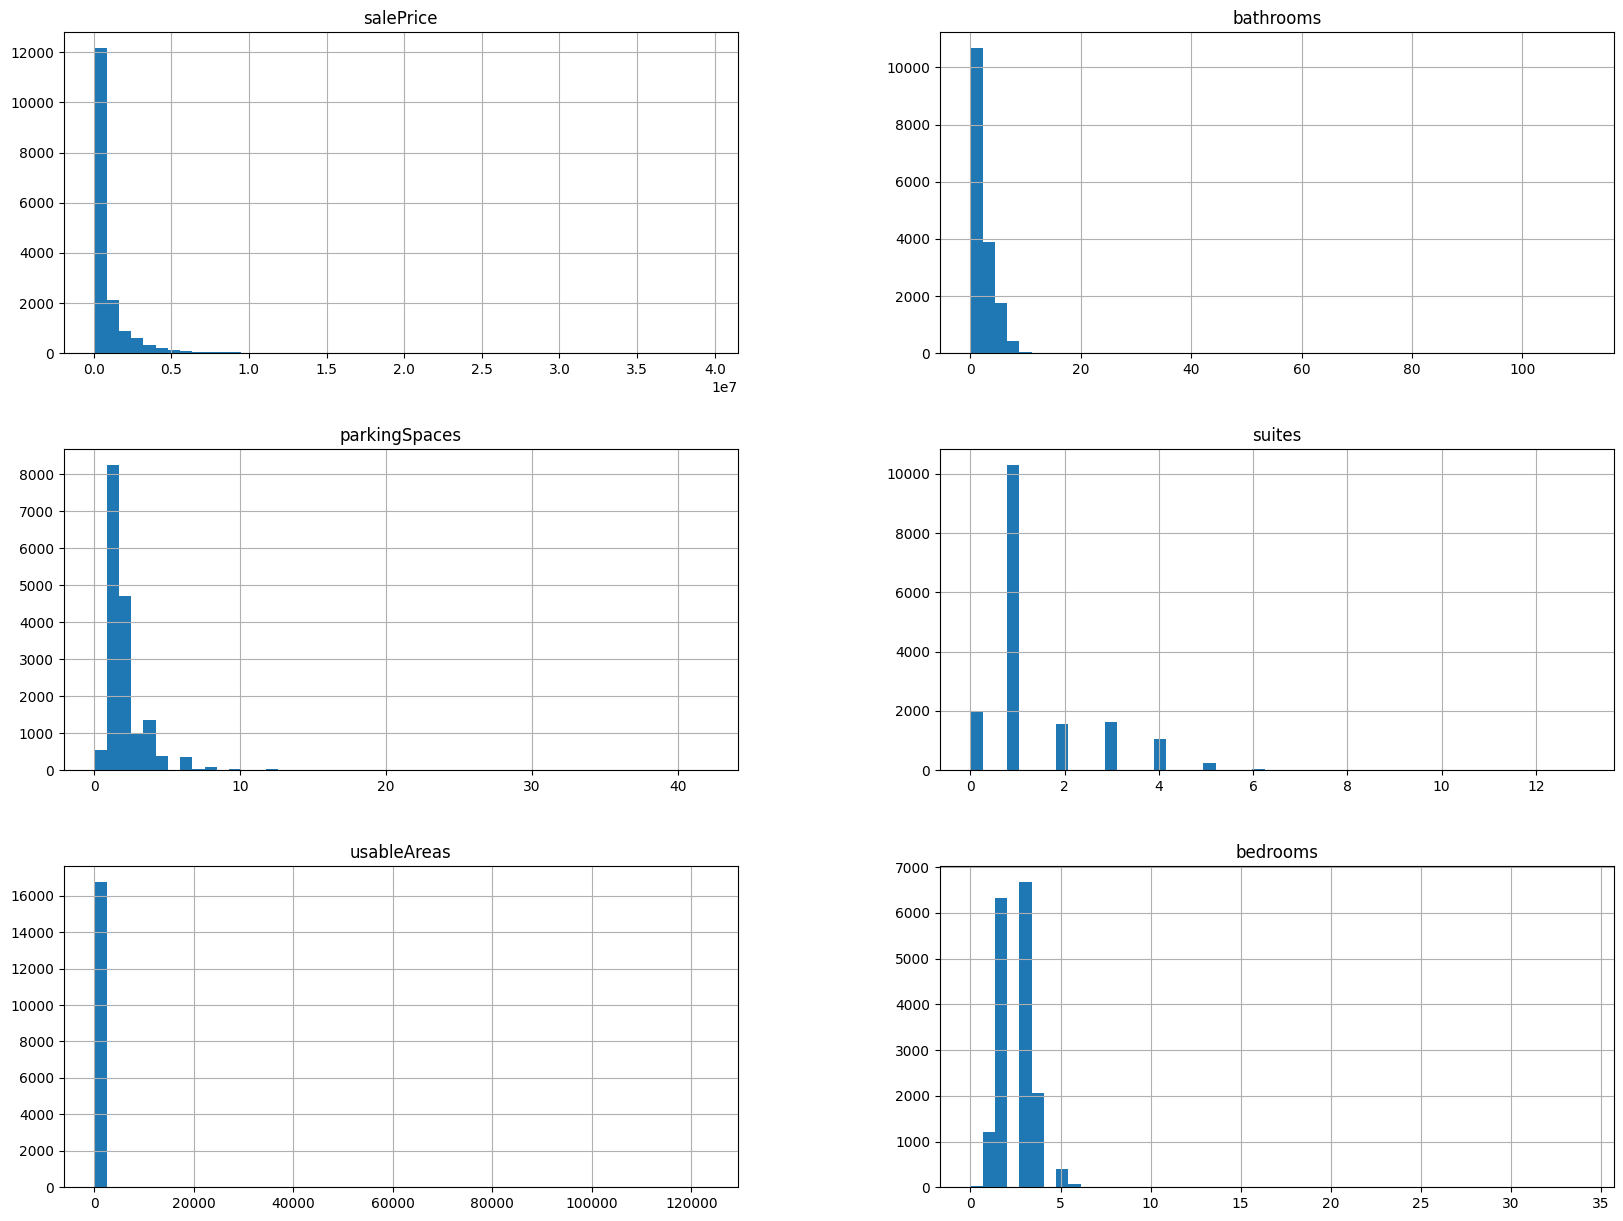

In [ ]:
# Histogram
%matplotlib inline
atributos = ['salePrice', 'bathrooms',
             'parkingSpaces', 'suites',
             'usableAreas', 'bedrooms']

df_reordered[atributos].hist(bins=50, figsize=(20,15))
plt.show()

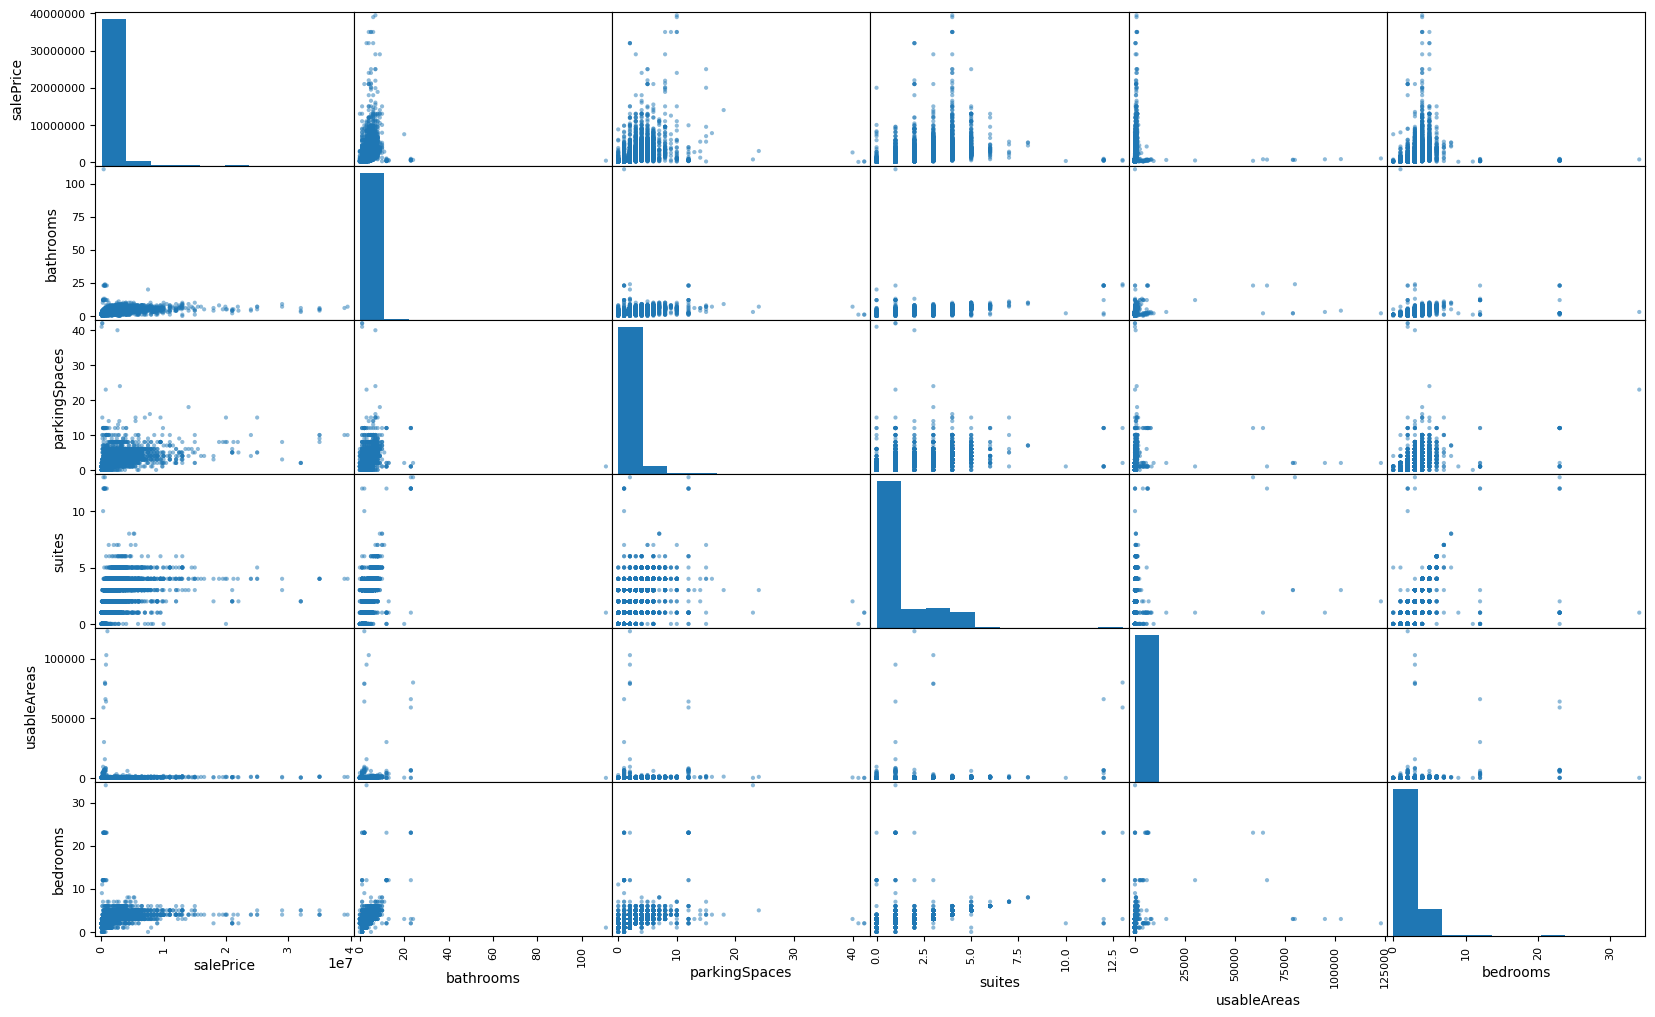

In [ ]:
# Scatter Matrix
from pandas.plotting import scatter_matrix

scatter_matrix(df_reordered[atributos], figsize=(20, 12))
plt.show()

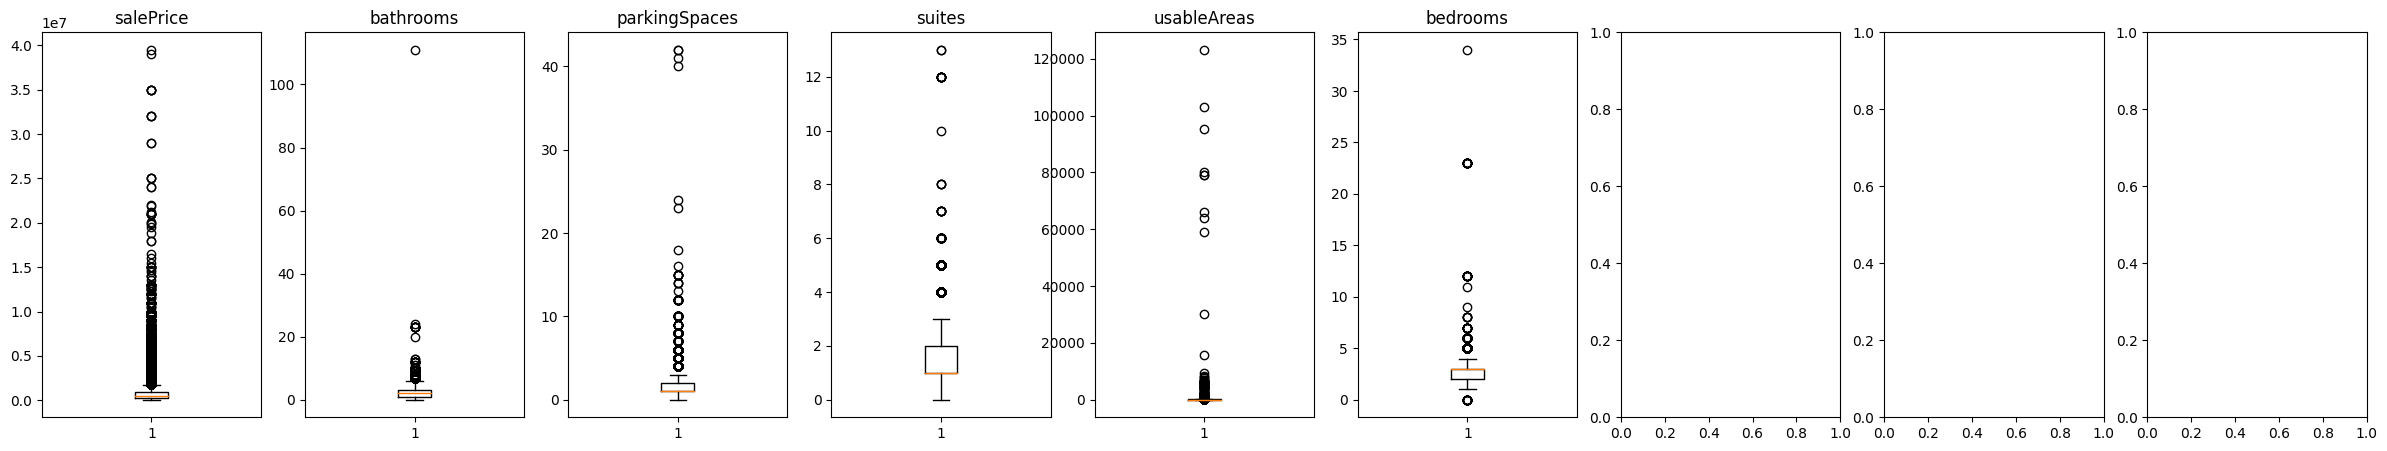

In [ ]:
# Boxplot
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(30, 5))

columns = [str(column) for column in df_reordered[atributos].columns]
for num, name in enumerate(columns):
  axs[num].boxplot(df_reordered[name])
  axs[num].set_title(name)

plt.show()

## Pré-processamento

In [ ]:
# Transformando os valores booleanos em númericos(binários)
booleanos = df_reordered.select_dtypes(include='bool').columns

le = LabelEncoder()

list_cat = []

for c in booleanos:
  bool_cat = le.fit_transform(df_reordered[c])
  list_cat.append(bool_cat)

for c in range(len(list_cat)):
  df_reordered[booleanos[c]] = list_cat[c]

In [ ]:
# Transformando os valores multicategóricos em numéricos
categoricos = df_reordered.select_dtypes(include='object').columns

ohe = OneHotEncoder(categories='auto')

feature_arr = ohe.fit_transform(df_reordered[categoricos]).toarray()
feature_labels = ohe.get_feature_names_out(categoricos)

cols_trans = pd.DataFrame(feature_arr, columns=feature_labels)
cols_trans

,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio,address.region_Centro-Oeste,address.region_Nordeste,address.region_Norte,address.region_Sudeste,address.region_Sul
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16815,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16816,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16817,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16818,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Unindo os dataframes
df_ohe = pd.concat([df_reordered, cols_trans], axis=1)

# Dropando as colunas antigas
df_ohe = df_ohe.drop(categoricos, axis=1)

In [ ]:
# Conferindo se restam valores vazios
num_nan = df_ohe.isna().sum()
print("Quantidade de valores NaN na coluna:\n", num_nan)

Quantidade de valores NaN na coluna:
 bathrooms                        4039
parkingSpaces                    4039
suites                           4039
monthlyCondoFee                  4039
usableAreas                      4039
bedrooms                         4039
backyard                         4039
barbgrill                        4039
bathtub                          4039
fireplace                        4039
furnished                        4039
garden                           4039
guestpark                        4039
gym                              4039
hottub                           4039
partyhall                        4039
playground                       4039
pool                             4039
sauna                            4039
sportcourt                       4039
tenniscourt                      4039
salePrice                        4039
imvl_type_apartamentos           4039
imvl_type_casas                  4039
imvl_type_casas-de-condominio    4039
imvl_type_ca

In [ ]:
# Dropando alguns valores varios para aplicar o OneHotEncoder
df_ohe = df_ohe.dropna(how='any', axis=0)

In [ ]:
# Convertendo as colunas númericas de float para integer
colunas_numericas = df_ohe.select_dtypes(include = 'float64').columns

df_ohe[colunas_numericas] = df_ohe[colunas_numericas].astype('int64')

In [ ]:
# Normalizando os dados
# Foram testados os dois tipos de pré-processamento

'''scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_ohe)

df_almost_finished = scaler.inverse_transform(scaled_data)'''

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_ohe)

df_almost_finished = scaler.inverse_transform(scaled_data)

## Finalização
O dataframe final passou por algumas mudanças importantes:
1. As features booleanas foram transformadas em valores binários por meio do LabelEncoder().
2. As features multicategóricas também foram transformadas por meio do OneHotEncoder().
3. Após essas mudanças o dataframe precisou ser ajustado algumas vezes:
- Dropando os valores vazios que foram surgindo.
- Reconvertendo os tipos dos dados.
4. Por fim, Realizamos a normalização desses dados, dois metódos foram testados: MinMaxScaler() e StandardScaler(), o segundo acabou se encaixando melhor com os dados tratados.


Observação: o tratamento dos outliers também foi feito no final, isso aconteceu pois estavamos tendo uma perda grande de dados com essas mudanças, por conta disso, optamos pro fazer no final. Ademais, alguns modelos foram treinandos com tratametos diferentes de outliers e isso será especificado em cada modelo.


In [ ]:
# Criando o dataframe definitivo para as análises do modelos
df_imoveis_final = pd.DataFrame(df_almost_finished, columns = df_ohe.columns).astype("int64")

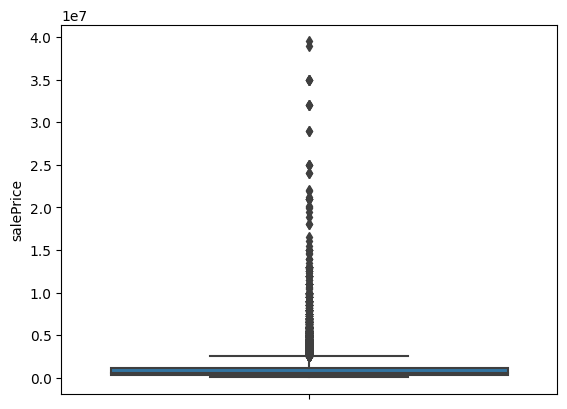

In [ ]:
# Identificando os outliers
sns.boxplot(y=df_imoveis_final['salePrice'])
plt.show()

In [ ]:
# Tratando os outliers
Tquart = np.quantile(df_imoveis_final['salePrice'], 0.75)
Fquart = np.quantile(df_imoveis_final['salePrice'], 0.25)

df_imoveis_final = df_imoveis_final[(df_imoveis_final['salePrice'] < Tquart) &
                                  (df_imoveis_final['salePrice'] > Fquart)]

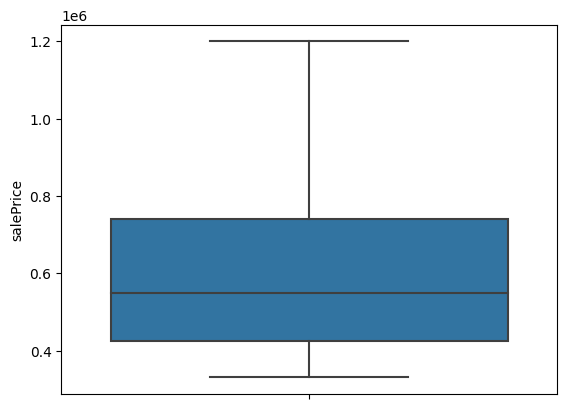

In [ ]:
# Conferindo os resultados
sns.boxplot(y=df_imoveis_final['salePrice'])
plt.show()

In [ ]:
# Criando o dataframe final para o treinamento dos modelos
df_imoveis_final.to_csv("df_vendas_final.csv", index = False) # salvando

print("Salvou.")

Salvou.
